# Второй файл

Не успеваю написать коментарии и запустить полностью код на всех кадрах с одеждой, поэтому отрисовала только на 5 первых кадрах. Чуть позже по времени загружу послностью проработанный код (по времени на отработку всего нужно около 3 часов)

Последний этап, отрисовка.

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
!cp '/gdrive/MyDrive/mocapoutput/Mesh_body/results.pkl' /content
!cp '/gdrive/MyDrive/mocapoutput/Mesh_body/v.pkl' /content
!cp '/gdrive/MyDrive/mocapoutput/Mesh_body/f.pkl' /content

In [3]:
!apt-get install x11-utils > /dev/null 2>&1 
!pip install pyglet > /dev/null 2>&1 
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1


In [4]:
!git clone https://github.com/facebookresearch/frankmocap.git
!sudo apt-get install ffmpeg libosmesa6-dev

Cloning into 'frankmocap'...
remote: Enumerating objects: 605, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 605 (delta 96), reused 132 (delta 74), pack-reused 431
Receiving objects: 100% (605/605), 283.74 KiB | 10.51 MiB/s, done.
Resolving deltas: 100% (346/346), done.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0

In [5]:
!pip install imgaug==0.2.6
!pip install -r docs/requirements.txt
!git clone https://github.com/polmorenoc/opendr.git

%cd /content/frankmocap/opendr/opendr/
!python setup.py build
!python setup.py install
%cd /content/frankmocap

!pip install torchgeometry
!pip install smplx

!sh scripts/install_frankmocap.sh

     |████████████████████████████████| 631 kB 26.5 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654017 sha256=e6fd89eb30f511f280c316e4ccb7d21bdc36a9f3ed476aae18a2af3985c8611a
  Stored in directory: /root/.cache/pip/wheels/89/72/98/3ebfdba1069a9a8eaaa7ae7265cfd67d63ef0197aaee2e5f9c
Successfully built imgaug
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'docs/requirements.txt'
Cloning into 'opendr'...
remote: Enumerating objects: 745, done.
remote: Total 745 (delta 0), reused 0 (delta 0), pack-reused 745
Receiving objects: 100% (745/745), 24.59 MiB | 34.78 MiB/s, done.
Resolving deltas: 100% (417/417), done.
[Errno 2] No such file or directory: '/content/frankmocap/opendr/opendr/'
/content
python3: can't open file 'setup.py': [Errno 2] No such file or directory
python3: can

In [6]:
!sudo apt-get update -y
!sudo apt-get install -y xvfb 

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security/multiverse amd64 Packages [21.1 kB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,468 kB]
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos

In [7]:
!cp '/gdrive/My Drive/files/demo_options_2.py' /content/frankmocap/bodymocap/
!cp '/gdrive/My Drive/files/viewer2D.py' /content/frankmocap/renderer/viewer2D.py

In [8]:
%cd /content/frankmocap
import os
import sys
import os.path as osp
import torch
from torchvision.transforms import Normalize
import numpy as np
import cv2
import argparse
import json
import pickle
from datetime import datetime

from bodymocap.demo_options_2 import DemoOptions
import mocap_utils.demo_utils as demo_utils
import mocap_utils.general_utils as gnu
from mocap_utils.timer import Timer

import renderer.image_utils as imu
from renderer.viewer2D import ImShow

from bodymocap import constants
from bodymocap.utils.imutils import crop, crop_bboxInfo, process_image_bbox, process_image_keypoints, bbox_from_keypoints
from mocap_utils.coordconv import convert_smpl_to_bbox, convert_bbox_to_oriIm
#%cd /content

/content/frankmocap


In [9]:
%cd /content
f = pickle.load(open('f.pkl', 'rb'), encoding='latin1')
v = pickle.load(open('v.pkl', 'rb'), encoding='latin1')
%cd /content/frankmocap

/content
/content/frankmocap


In [10]:
args = DemoOptions().parse()
video_path = '/gdrive/MyDrive/videolocation/video.mp4'
output_path = '/gdrive/MyDrive/mocapoutput/Subfolder'

args.input_path = video_path
args.out_dir = output_path

input_type, input_data = demo_utils.setup_input(args)
print(args.renderer_type, input_type, input_data)

use_smplx = args.use_smplx
checkpoint_path = args.checkpoint_body_smplx if use_smplx else args.checkpoint_body_smpl

opengl video <VideoCapture 0x7fa983490830>


In [11]:
%cd /content/frankmocap
if args.renderer_type in ['pytorch3d', 'opendr']:
    from renderer.screen_free_visualizer import Visualizer
else:
    from renderer.visualizer import Visualizer
#%cd /content

/content/frankmocap


In [12]:
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()
visualizer = Visualizer(args.renderer_type)

/content
(1080, 1228, 3) (1080, 614, 3)


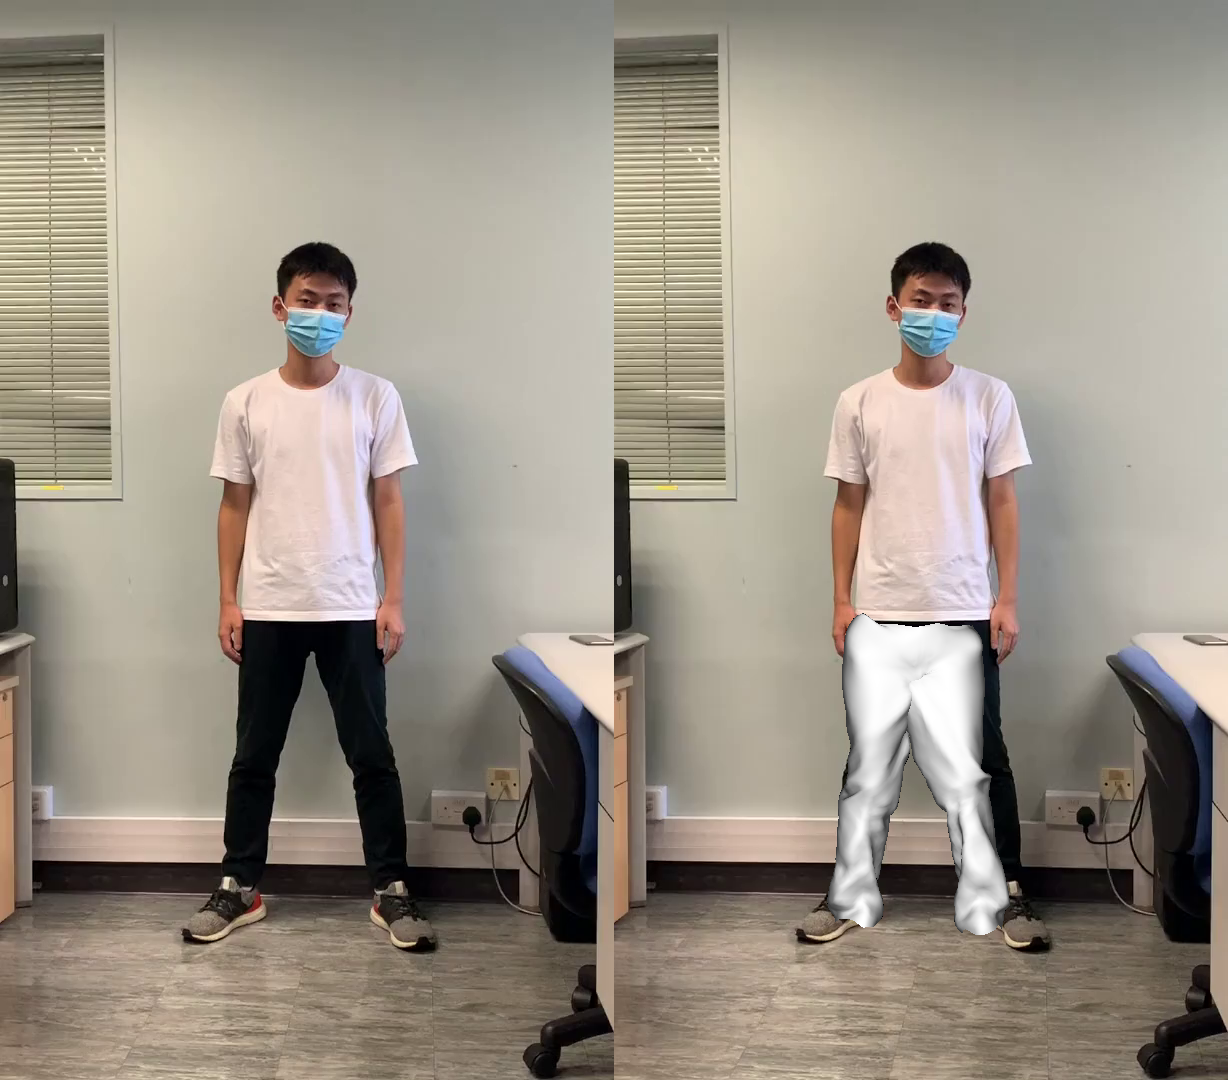

Visualization saved: /gdrive/MyDrive/mocapoutput/Subfolder/rendered/00000.jpg
Time: 2.50 sec/frame, FPS 0.40
Processed : /gdrive/MyDrive/mocapoutput/Subfolder/frames/00000.jpg
(1080, 1228, 3) (1080, 614, 3)


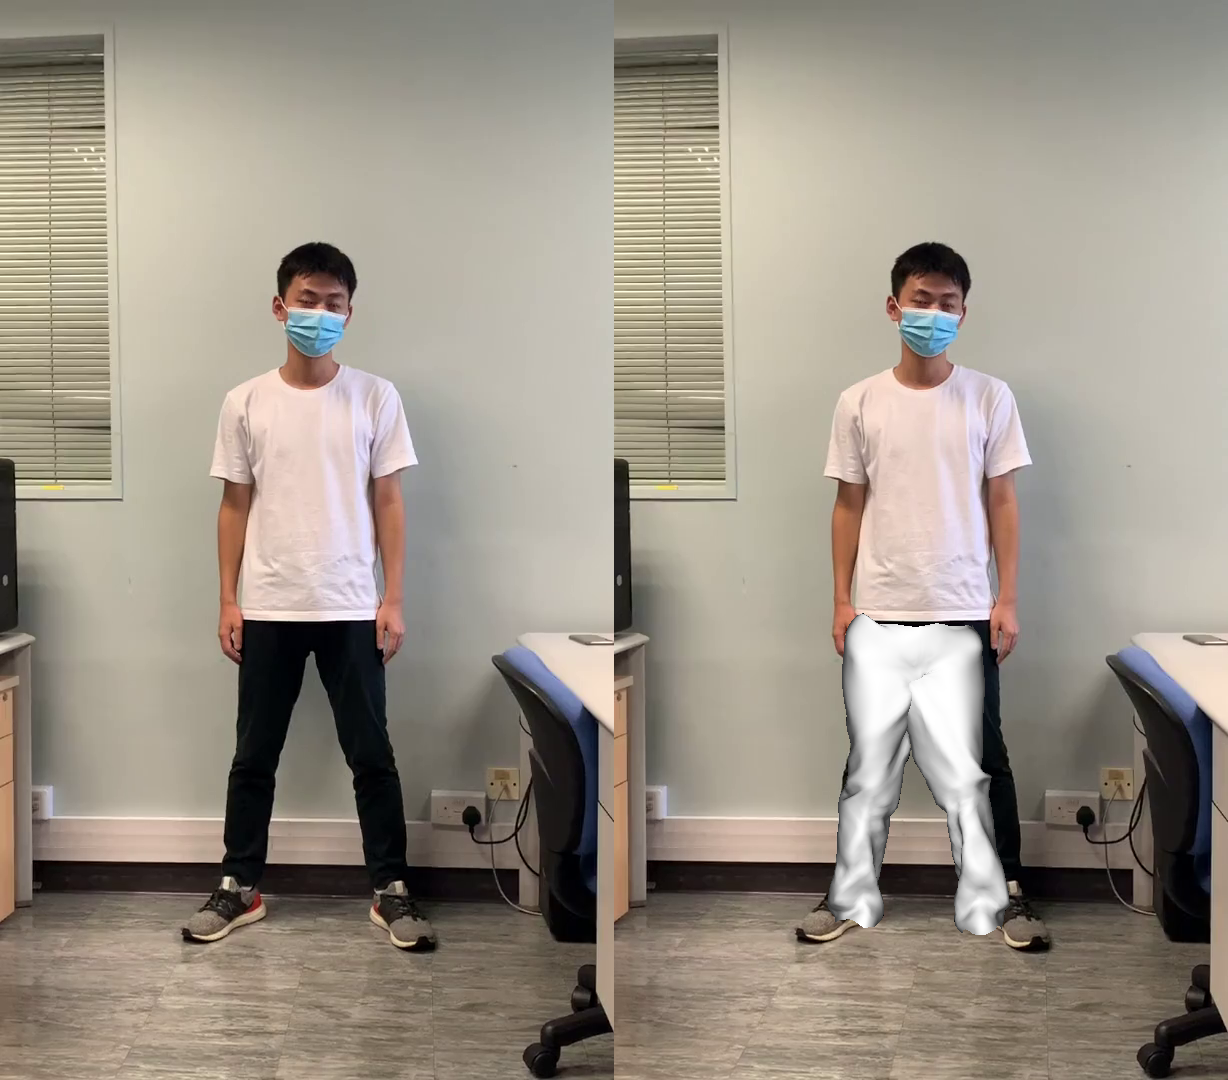

Visualization saved: /gdrive/MyDrive/mocapoutput/Subfolder/rendered/00001.jpg
Time: 1.00 sec/frame, FPS 1.00
Processed : /gdrive/MyDrive/mocapoutput/Subfolder/frames/00001.jpg
(1080, 1228, 3) (1080, 614, 3)


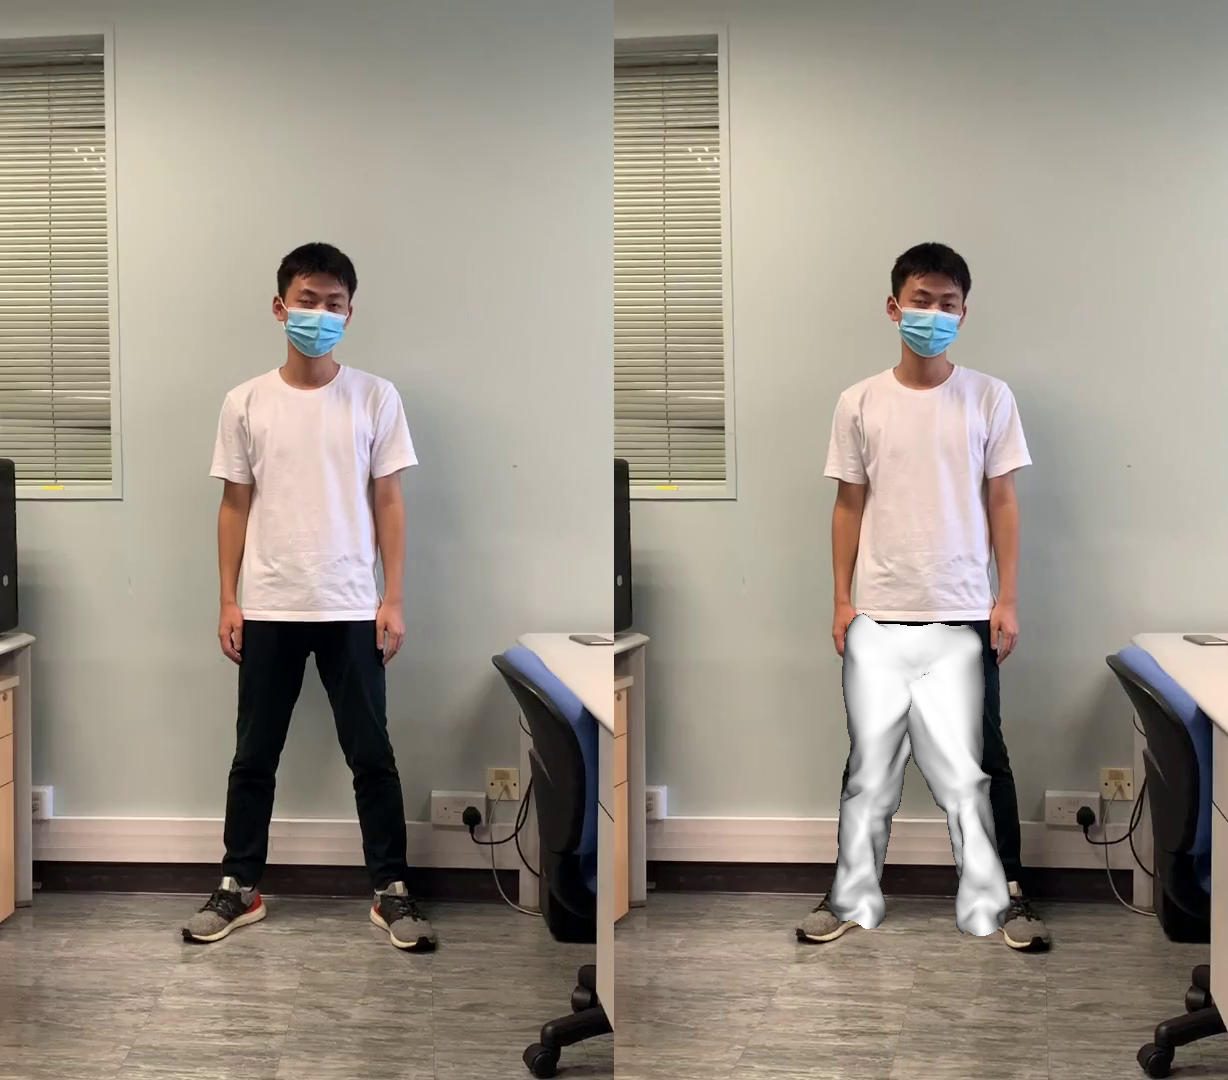

Visualization saved: /gdrive/MyDrive/mocapoutput/Subfolder/rendered/00002.jpg
Time: 1.05 sec/frame, FPS 0.95
Processed : /gdrive/MyDrive/mocapoutput/Subfolder/frames/00002.jpg
(1080, 1228, 3) (1080, 614, 3)


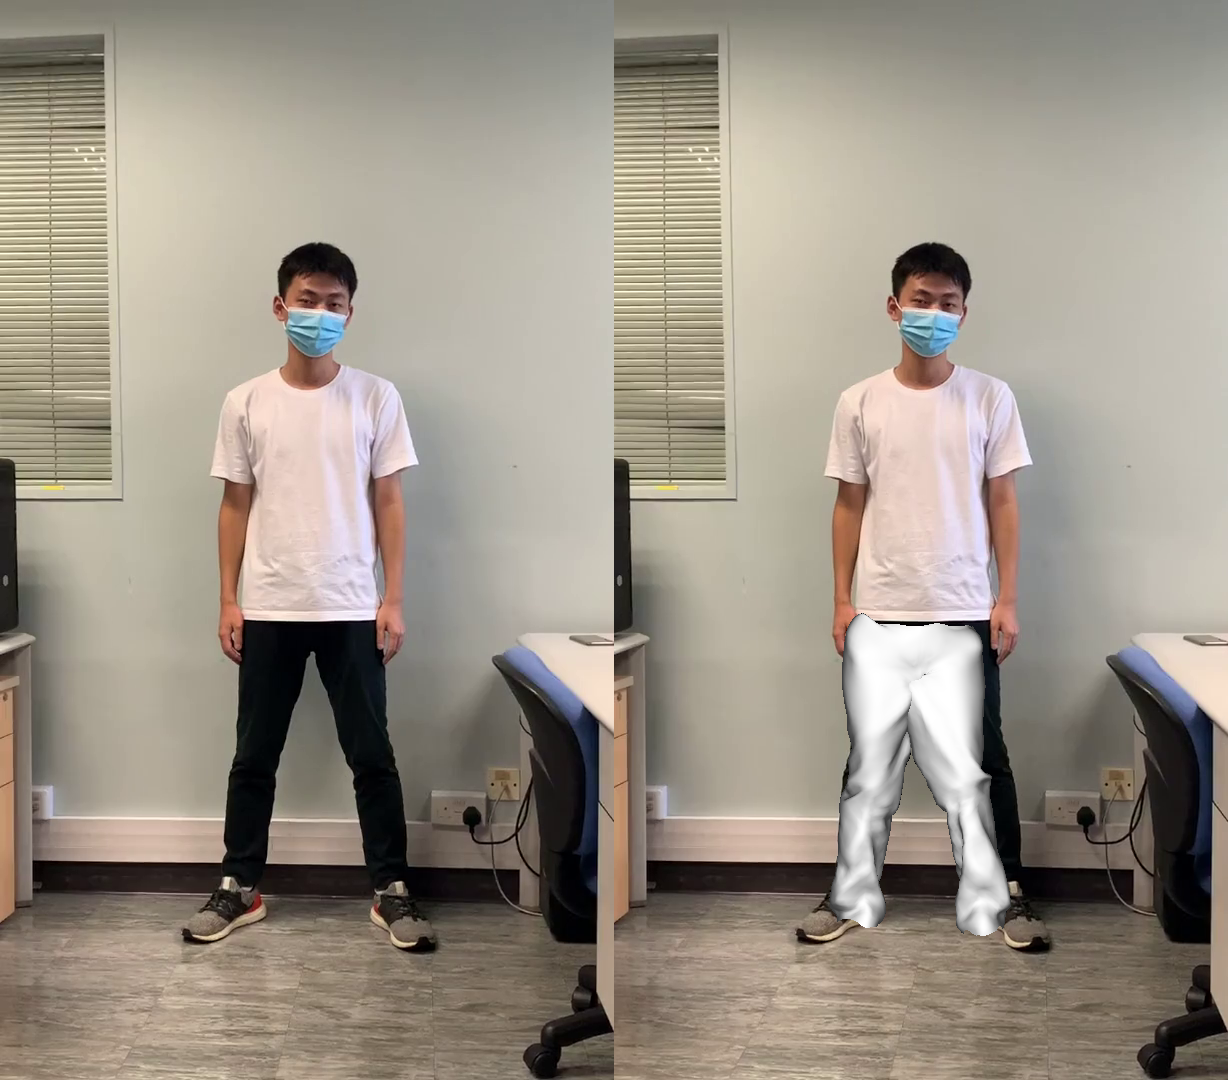

Visualization saved: /gdrive/MyDrive/mocapoutput/Subfolder/rendered/00003.jpg
Time: 1.20 sec/frame, FPS 0.83
Processed : /gdrive/MyDrive/mocapoutput/Subfolder/frames/00003.jpg
(1080, 1228, 3) (1080, 614, 3)


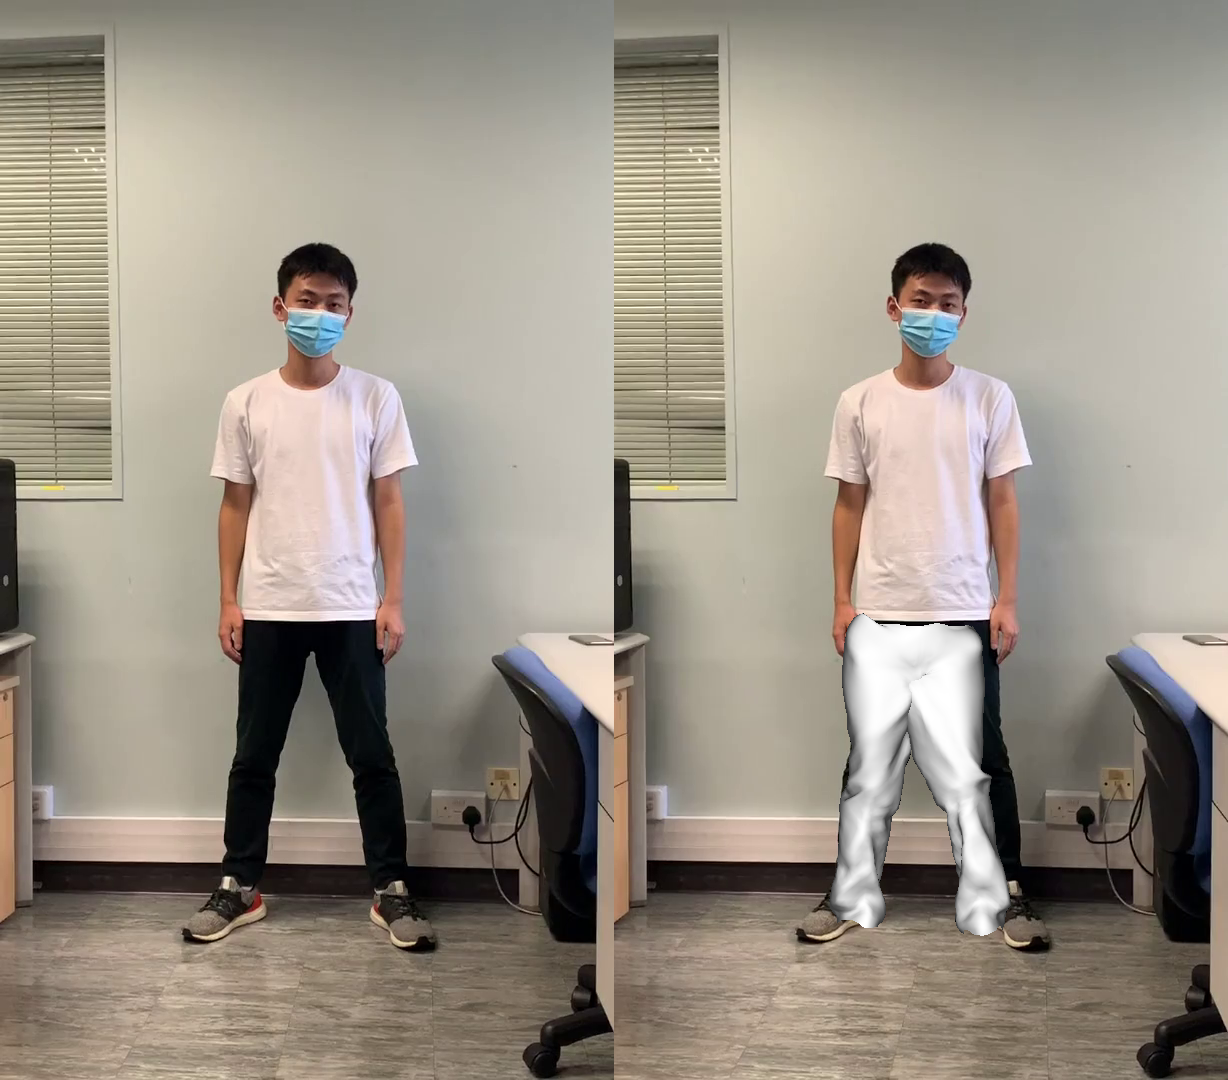

Visualization saved: /gdrive/MyDrive/mocapoutput/Subfolder/rendered/00004.jpg
Time: 0.99 sec/frame, FPS 1.01
Processed : /gdrive/MyDrive/mocapoutput/Subfolder/frames/00004.jpg


IndexError: ignored

In [13]:
%cd /content
cur_frame = args.start_frame
video_frame = 0
timer = Timer()
vertconst = 350
#vertconst2 = -600
i = 0

vertconst2 = np.array([300, 710, 0]).reshape(-1, 3)
while True:
    timer.tic()
    # load data
    load_bbox = False

    if input_type =='image_dir':
        if cur_frame < len(input_data):
            image_path = input_data[cur_frame]
            img_original_bgr  = cv2.imread(image_path)
        else:
            img_original_bgr = None

    elif input_type == 'bbox_dir':
        if cur_frame < len(input_data):
            print("Use pre-computed bounding boxes")
            image_path = input_data[cur_frame]['image_path']
            hand_bbox_list = input_data[cur_frame]['hand_bbox_list']
            body_bbox_list = input_data[cur_frame]['body_bbox_list']
            img_original_bgr  = cv2.imread(image_path)
            load_bbox = True
        else:
            img_original_bgr = None

    elif input_type == 'video':      
        _, img_original_bgr = input_data.read()
        if video_frame < cur_frame:
            video_frame += 1
            continue
        # save the obtained video frames
        image_path = osp.join(args.out_dir, "frames", f"{video_frame:05d}.jpg")
        if img_original_bgr is not None:
            video_frame += 1
            if args.save_frame:
                gnu.make_subdir(image_path)
                cv2.imwrite(image_path, img_original_bgr)

    elif input_type == 'webcam':    
        _, img_original_bgr = input_data.read()

        if video_frame < cur_frame:
            video_frame += 1
            continue
        # save the obtained video frames
        image_path = osp.join(args.out_dir, "frames", f"scene_{cur_frame:05d}.jpg")
        if img_original_bgr is not None:
            video_frame += 1
            if args.save_frame:
                gnu.make_subdir(image_path)
                cv2.imwrite(image_path, img_original_bgr)
    else:
        assert False, "Unknown input_type"
    

    pred_output_list = pickle.load(open('results.pkl', 'rb'), encoding='latin1')[i]
    pred_mesh_list = demo_utils.extract_mesh_from_output(pred_output_list)
    #print(img_original_bgr)
    pred_mesh_list[0]['faces']=f[i]
    pred_mesh_list[0]['vertices']=v[i]*vertconst + vertconst2

    res_img = visualizer.visualize(
            img_original_bgr,
            pred_mesh_list = pred_mesh_list)
    print(res_img.shape, img_original_bgr.shape)
    # show result in the screen
    if not args.no_display:
        res_img = res_img.astype(np.uint8)
        ImShow(res_img)

    # save result image
    if args.out_dir is not None:
        demo_utils.save_res_img(args.out_dir, image_path, res_img)

    # save predictions to pkl
    if args.save_pred_pkl:
        demo_type = 'body'
        demo_utils.save_pred_to_pkl(
          args, demo_type, image_path, body_bbox_list, hand_bbox_list, pred_output_list)

    timer.toc(bPrint=True,title="Time")
    print(f"Processed : {image_path}")
    i+=1
#save images as a video
if not args.no_video_out and input_type in ['video', 'webcam']:
    demo_utils.gen_video_out(args.out_dir, args.seq_name)

if input_type =='webcam' and input_data is not None:
    input_data.release()
    cv2.destroyAllWindows()
display.stop()
